### Assignment 3: Coarse Graining

As you have seen, membrane are slow moving. Depending on what you want to observe and the computational resources available, this can make all-atom simulations unfeasible. Luckily we can use a coarse-grained (CG) system.

In general, coarse-graining involves grouping toegether several atoms into individual interaction sites. This reduces the number of beads, enables stability at larger step times, and smoothens the energy landscapes. This improves the available sampling. We focus on the MARTINI forcefield (https://cgmartini.nl/). This is one of the most widely using CG forefields, and has been parameterised extensively for lipid and protein simulations. We'd highly recommend their tutorials as they cover a wide range of different uses for CG.  

In the standard MARTINI model, four heavy atoms are typically represented by a single coarse-grained bead, although this can vary depending on the chemical nature of the molecule. Each bead represents a specific type of interaction site, categorized based on polarity and hydrogen-bonding capability. The main bead classes are nonpolar (C), polar (P), apolar (N), and charged (Q), each with subtypes to capture finer chemical differences. This systematic classification allows MARTINI to reproduce key physicochemical properties, such as solubility and lipid phase behavior, while maintaining simplicity. The 4:1 mapping also makes it intuitive to construct new molecules by combining bead types much like assembling with Lego blocks, balancing chemical realism with computational efficiency.

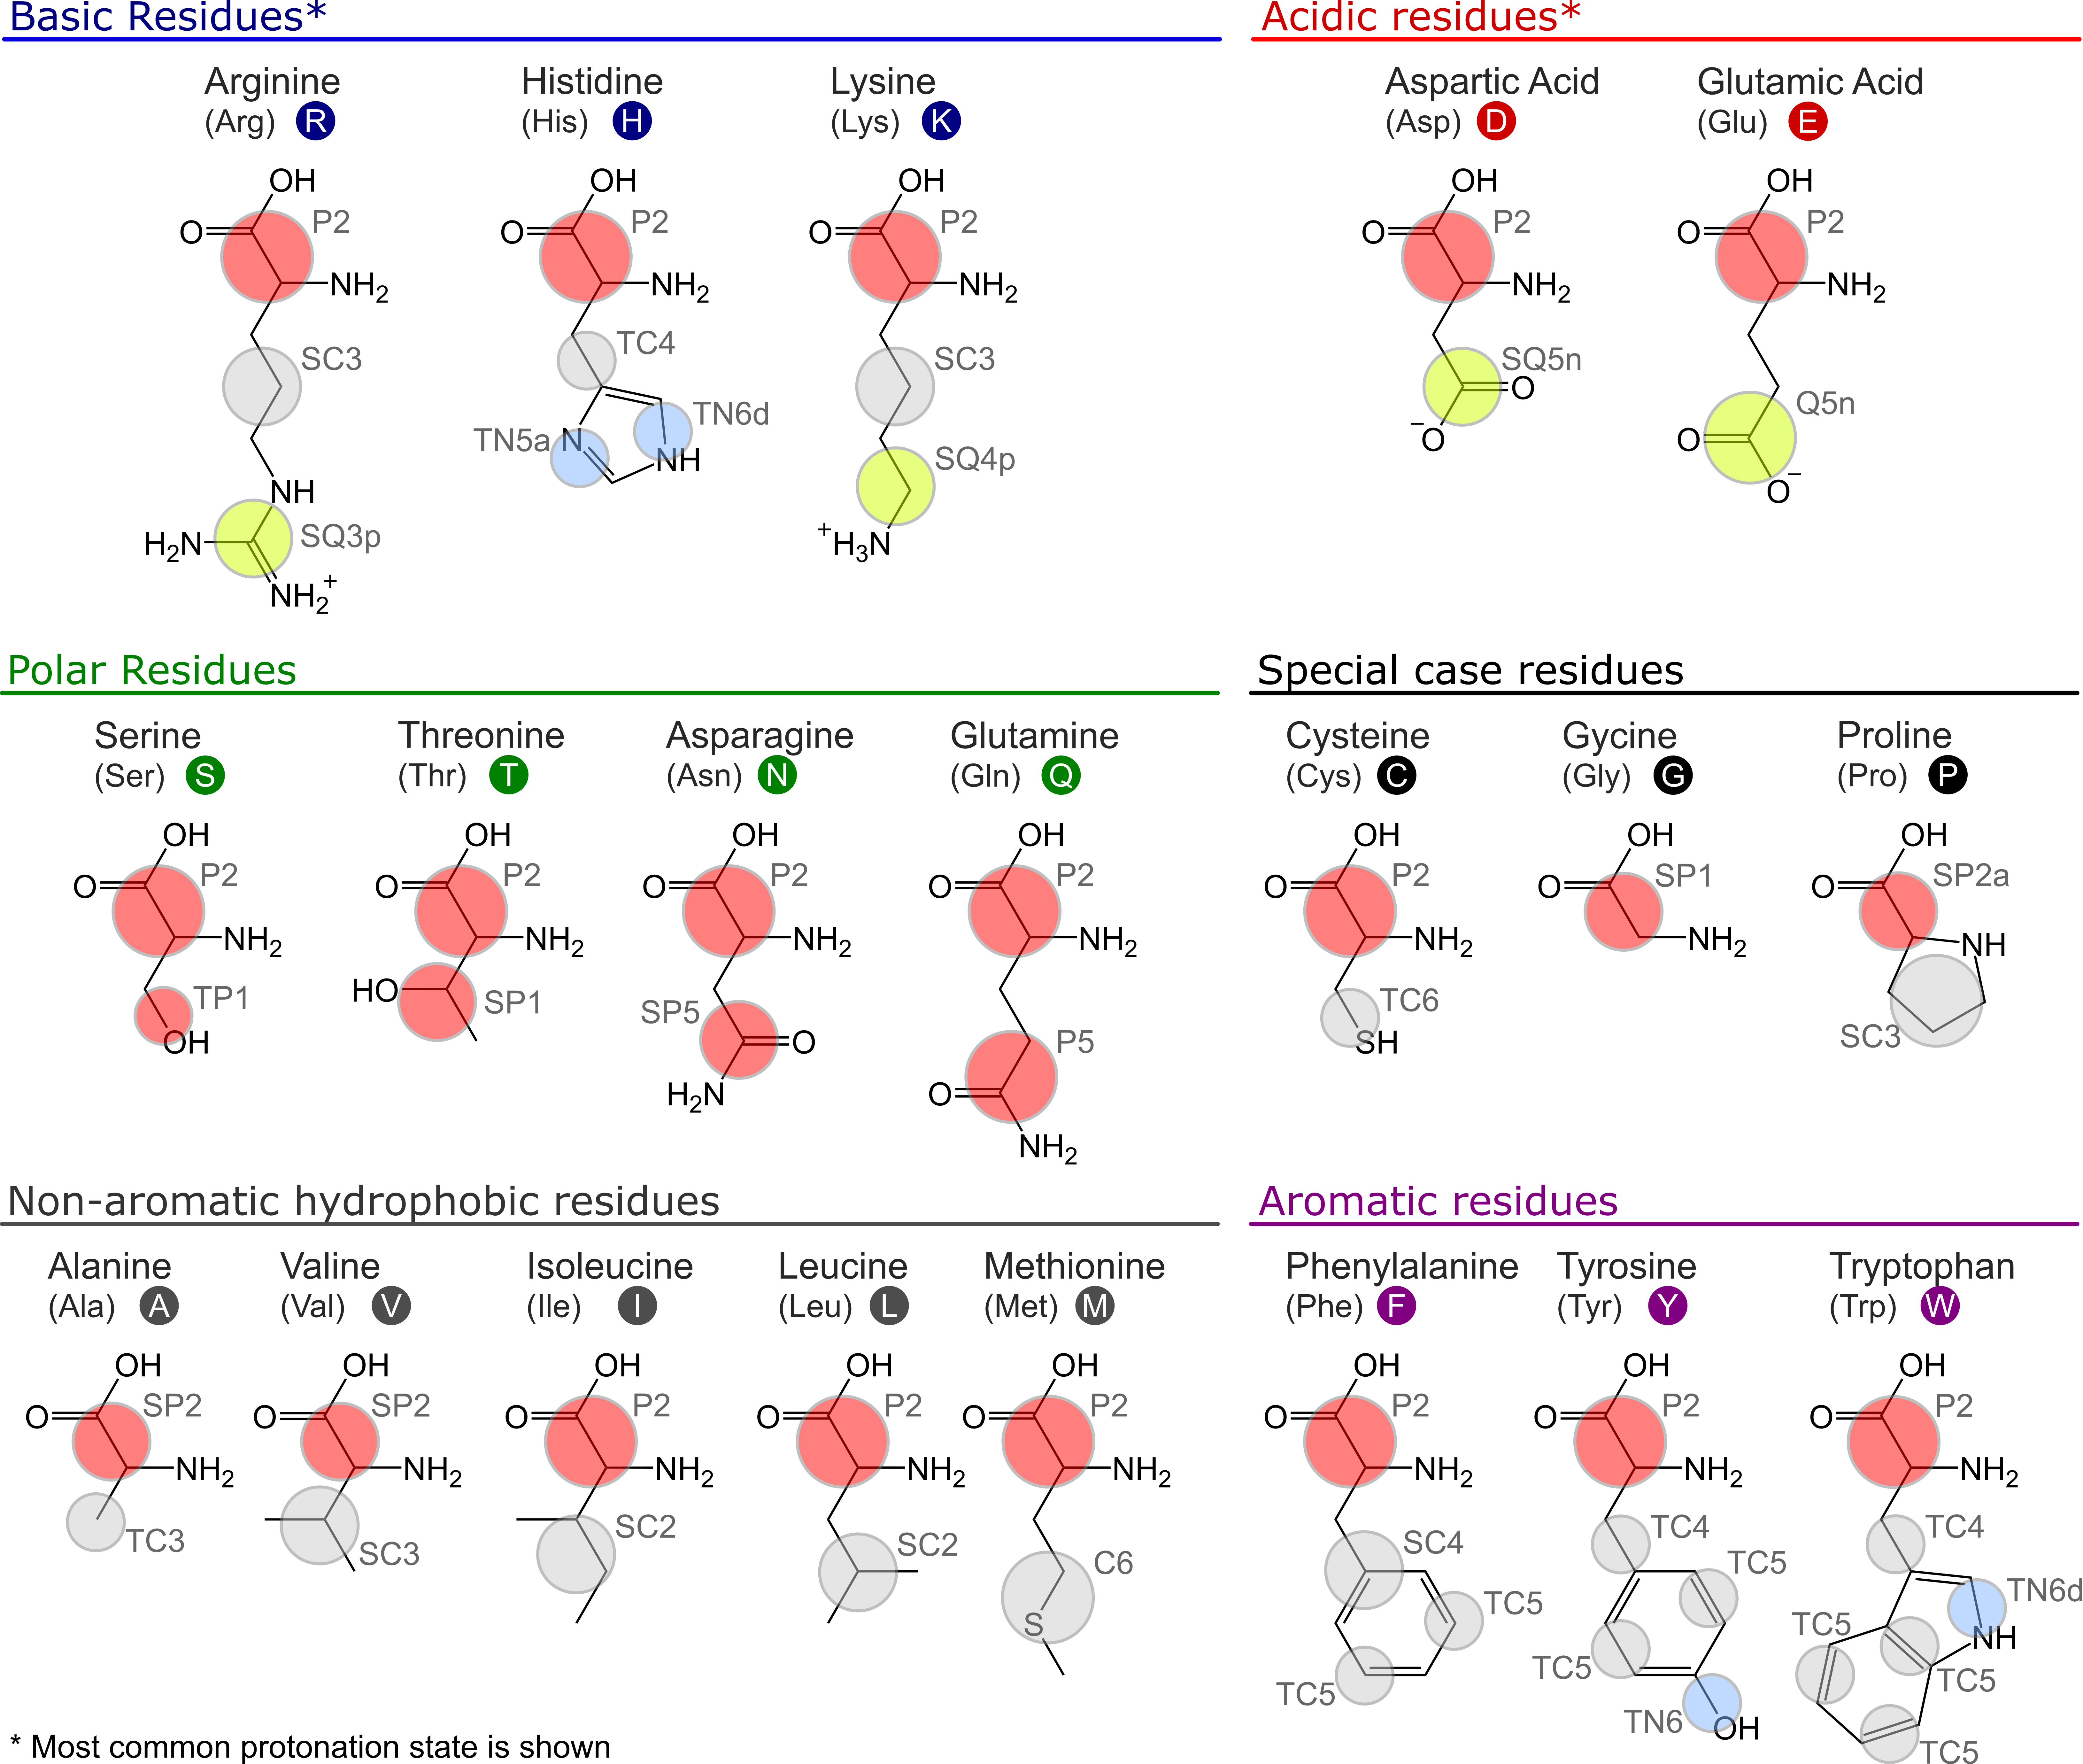


https://cgmartini.nl/docs/tutorials/Martini3/ProteinsI/

Charmm-GUI has a MARTINI maker option (https://www.charmm-gui.org/?doc=input/martini.bilayer). This can be used to set up membrane simulations. However, we often want higher throughput or more flexibility, so in this practical we are going to do it directly.

#### Part 3.1 Elastic networks

Elastic networks are commonly used in coarse-grained simulations to help maintain the structural stability of biomolecules. Since coarse-graining smooths the energy landscape and removes detailed interactions such as explicit hydrogen bonding, proteins can sometimes become too flexible or lose their native structure. Elastic networks mitigate for this by connecting selected beads with harmonic springs, preserving the correct fold but potentially restricting the correct dynamics of the protein. Martinize2 automates the setup of MARTINI coarse-grained models and can include an elastic network as part of the conversion, making it easier to generate stable and well-behaved systems for simulation. Let's look at the options for martinize2.

In [13]:
!martinize2 -h

usage: martinize2 [-h] [-V] [-f INPATH] [-x OUTPATH] [-o TOP_PATH] [-sep]
                  [-merge MERGE_CHAINS] [-name MOLNAME]
                  [-resid RESID_HANDLING]
                  [-ignore IGNORE_RES [IGNORE_RES ...]] [-ignh]
                  [-model MODELIDX] [-bonds-from {name,distance,none,both}]
                  [-bonds-fudge BONDS_FUDGE] [-ff TO_FF] [-from FROM_FF]
                  [-ff-dir EXTRA_FF_DIR] [-map-dir EXTRA_MAP_DIR] [-list-ff]
                  [-list-blocks] [-p {none,all,backbone}] [-pf POSRES_FC]
                  [-dssp [DSSP] | -ss SEQUENCE | -collagen] [-ed] [-elastic]
                  [-ef RB_FORCE_CONSTANT] [-el RB_LOWER_BOUND]
                  [-eu RB_UPPER_BOUND] [-ermd RES_MIN_DIST]
                  [-ea RB_DECAY_FACTOR] [-ep RB_DECAY_POWER]
                  [-em RB_MINIMUM_FORCE] [-eb RB_SELECTION] [-eunit RB_UNIT]
                  [-go [GO]] [-go-eps GO_EPS] [-go-low GO_LOW] [-go-up GO_UP]
                  [-go-res-dist GO_RES_DIST] [-g

We are going to use a simple set of options for the elastic network but there are many other approaches available that can retain stability while enabling flexibility in specific regions. As we eluded to before, a downside of an elastic network model can be that it prevents certain domain motions which should happen but are now restricted, so some consideration of the network is essential.

In [14]:
!martinize2   -f 6AL2_A.pdb   -x 6AL2_CG.pdb   -o topol.top   -ff martini3001   -dssp   -elastic

    INFO - general - Read 1 molecules from PDB file 6AL2_A.pdb
    INFO - step - Guessing the bonds.
    INFO - general - 1 molecules after guessing bonds
    INFO - step - Repairing the graph.
    INFO - general - Applying modification N-ter to residue A-ASP49
    INFO - general - Applying modification + to residue A-ASP49
    INFO - general - Applying modification C-ter to residue A-TYR532
    INFO - general - Applying modification + to residue A-TYR532
    INFO - missing-atom - Missing atom TYR532:OXT
    INFO - step - Dealing with modifications.
    INFO - general - Identified the modifications ['N-ter'] on residues ['ASP49', 'ASP49', 'ASP49', 'ASP49']
    INFO - general - Identified the modifications ['C-ter'] on residues ['TYR532', 'TYR532', 'TYR532']
    INFO - step - Read input.
    INFO - step - Creating the graph at the target resolution.
    INFO - general - Applying modification mapping ('N-ter',)
    INFO - general - Applying modification mapping ('C-ter',)
    INFO - step

Re-check `martinize2 -h` to have a look at what the default options are for the elastic flag. 

The `-dssp` flag determines secondary structure elements that control how backbone bead restraints are applied in the `.itp` file.

We are using MARTINI 3 here. 

### Part 3.2 Building the Membrane-Protein System

There are numerous different tools for building CG membrane systems. One of the most common is insane (https://github.com/Tsjerk/Insane), which is quite flexible. However, here we use COBY (https://github.com/MikkelDA/COBY). COBY is a powerful package for building many different types of membrane arrangement and we'd recommend the tutorials if the user wishes to build a more complex system. 

Here we use it to place our protein within a simple POPE:POPG bilayer with a 15:4 ratio. We exclude cardiolipin for simplicity's sake. The COBY documentation has ample instruction on how one may include non-standard lipid types.

In [15]:

import os
import shutil
from contextlib import contextmanager
import COBY
import MDAnalysis as mda
import numpy as np



base_name = "initial_state"
base_dir = "system"

# these are our martinize2 outputs and our inputs for COBY

protein_pdb   = "6AL2_CG.pdb"      
protein_itp   = "molecule_0.itp"   # 
molecule_type = "molecule_0"

toppar_src = "toppar"

# Relative ITP paths for MARTINI files
lipid_itp_dir = os.path.join("toppar", "M3-Lipid-Parameters", "ITPs")
m3_core_itp   = os.path.join(lipid_itp_dir, "martini_v3.0.0.itp")
ffbonded_itp  = os.path.join(lipid_itp_dir, "martini_v3.0.0_ffbonded_v2.itp")
pe_itp        = os.path.join(lipid_itp_dir, "martini_v3.0.0_phospholipids_PE_v2.itp")
pg_itp        = os.path.join(lipid_itp_dir, "martini_v3.0.0_phospholipids_PG_v2.itp")
solv_itp      = os.path.join(lipid_itp_dir, "martini_v3.0.0_solvents_v1.itp")
ions_itp      = os.path.join(lipid_itp_dir, "martini_v3.0.0_ions_v1.itp")

# Membrane paramter set up

membrane_spec = "lipid:POPE:75:params:default lipid:POPG:20:params:default"


Below are some utilities that enable us to run everything in a separate directory where we will put our outputs to keep our working directory clean. 
We copy a toppar folder into our directory so it can be more self-contained. We don't copy across some git-related files. The itp parameters were downloaded from https://github.com/Martini-Force-Field-Initiative/M3-Lipid-Parameters 


In [16]:
@contextmanager
def pushd(new_dir):
    prev = os.getcwd()
    os.chdir(new_dir)
    try:
        yield
    finally:
        os.chdir(prev)


system_dir = base_dir
os.makedirs(system_dir, exist_ok=True)

# Copy toppar and protein ITP files into the system directory
toppar_dest = os.path.join(system_dir, "toppar")
if os.path.exists(toppar_dest):
    shutil.rmtree(toppar_dest)

shutil.copytree(toppar_src, toppar_dest, ignore=shutil.ignore_patterns(".git", ".github", "__pycache__"))
shutil.copy(protein_itp, os.path.join(system_dir, os.path.basename(protein_itp)))


'system/molecule_0.itp'

We now build our system with COBY. The code below builds a 12 x 12 x 14 nm box with our mixed lipid bilayer. We solvate with water and include 0.15 M NaCl. This writes all outputs (`.gro`, `.top`, `.log`) inside the `system/` directory. One important thing to notice is that we shift our protein down in $z$ by 1 nm so that the membrane region properly aligns with the membrane. This can sometimes be an iterative process, and can be informed by using a server like OPM which we used earlier. 

In [17]:

protein_pdb_abs = os.path.abspath(protein_pdb)

with pushd(system_dir):
    print(f"\n--- Building {base_name} in {system_dir} ---\n")

    COBY.COBY(
        randseed=1,
        box=[12, 12, 14],
        box_type="rectangular",
        membrane=membrane_spec,
        protein=f"file:{protein_pdb_abs} moleculetypes:{molecule_type} cz:-1.0",
        solvation="solv:W pos:NA neg:CL salt_molarity:0.15",
        itp_input=[
            f"include:{m3_core_itp}",
            f"include:{ffbonded_itp}",
            f"include:{ions_itp}",
            f"include:{solv_itp}",
            f"include:{pe_itp}",
            f"include:{pg_itp}",
            f"include:{os.path.basename(protein_itp)}",
        ],
        out_sys="output_initial_state",
        out_top="topol.top",
        out_log="log_initial_state.log",
        verbose=1,
        sn=base_name,
    )

    print(f"--- Finished building {base_name} in {system_dir} ---\n")


--- Building initial_state in system ---

Setting random seed to: 1
-------------------------- PREPROCESSING DEFINITIONS ---------------------------
---------------------- DEFINITIONS PREPROCESSING COMPLETE ----------------------
                            (Time spent: 0.6813 [s])                            

---------------------------- PREPROCESSING COMMANDS ----------------------------
------------------------ COMMAND PREPROCESSING COMPLETE ------------------------
                            (Time spent: 0.0082 [s])                            

------------------------------ PROTEIN PLACEMENT -------------------------------
-------------------------- PROTEIN PLACEMENT COMPLETE --------------------------
                            (Time spent: 0.0781 [s])                             

----------------------- CREATING LEAFLET BOUNDARY BOXES ------------------------
------------------------ LEAFLET BOUNDARY BOXES CREATED ------------------------
                            (Time sp

Now is a good time to visualise our system and get used to visualising CG systems. 


Open up `output_initial_state.gro` in vmd.

We are dealing with beads so we can not use shortcuts like protein or membrane to visualise our system. There are some packages like MartiniGlass (https://github.com/Martini-Force-Field-Initiative/MartiniGlass) that can be used for visualisation but for this practical we will used a quicker but more basic approach. 


Check the gro file and remind yourself what backbone beads and draw them using QuickSurf. Hint: name < bead name >


Now lets visualise the phosphate beads (check gro file for name) and draw them using VDW. 


This is a quick and easy way of showing our backbone and the position of our membrane. We can look at the whole of the membrane using resname POPE POPG. See how it is extremely uniform. 



Play around with the $z$ value in the COBY system set up and visualise it. Try to match it to the OPM output from earlier. Coloring by ResType can also help you think about where the membrane should sit.  



### Part 3.3: Making an index file

We now have a fully constructed system. However, before we can proceed we must create an index file containing our temperature and pressure coupling groups. MDAnalysis provides fantastic selection capabilites making it ideal to perform this function. 

In [19]:

from MDAnalysis.selections.gromacs import SelectionWriter

with pushd(system_dir):
    gro = "output_initial_state.gro"
    u = mda.Universe(gro)

    # Define common selection groups
    sel_protein   = u.select_atoms("same resname as name BB") # as an aside, this is a quick way of visualising the whole protein if you use this selection 
    sel_membrane  = u.select_atoms("resname POPE POPG")
    sel_solvent   = u.select_atoms("resname W NA CL")
    sel_prot_bb   = u.select_atoms("name BB")
    sel_prot_mem  = sel_protein | sel_membrane

    groups = {
        "membrane": sel_membrane,
        "protein": sel_protein,
        "protein_membrane": sel_prot_mem,
        "solvent": sel_solvent,
        "protein_bb": sel_prot_bb,
    }

    # Write the .ndx file
    with SelectionWriter("index.ndx", mode="w") as ndx:
        for name, ag in groups.items():
            ndx.write(ag, name=name)

    print(f"--- index.ndx written in {system_dir} ---\n")





--- index.ndx written in system ---



Now open the notebook within the system directory and continue...